In [1]:
# Import required modules.
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [2]:
# Read the data into ds.
de = pd.read_csv('../data/MIT-BIH_Arrhythmia_Database.csv')

In [3]:
# Show the head of ds.
de.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [4]:
# Show the shape of ds.
de.shape

(100689, 34)

In [5]:
# Check for duplicates in ds.
de[de.duplicated()].sum()

record              0
type                0
0_pre-RR            0
0_post-RR         0.0
0_pPeak           0.0
0_tPeak           0.0
0_rPeak           0.0
0_sPeak           0.0
0_qPeak           0.0
0_qrs_interval      0
0_pq_interval       0
0_qt_interval       0
0_st_interval       0
0_qrs_morph0      0.0
0_qrs_morph1      0.0
0_qrs_morph2      0.0
0_qrs_morph3      0.0
0_qrs_morph4      0.0
1_pre-RR            0
1_post-RR         0.0
1_pPeak           0.0
1_tPeak           0.0
1_rPeak           0.0
1_sPeak           0.0
1_qPeak           0.0
1_qrs_interval      0
1_pq_interval       0
1_qt_interval       0
1_st_interval       0
1_qrs_morph0      0.0
1_qrs_morph1      0.0
1_qrs_morph2      0.0
1_qrs_morph3      0.0
1_qrs_morph4      0.0
dtype: object

In [6]:
# Check for missing values in ds.
de.isnull().sum()

record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

In [7]:
# Get the statistics of ds.
dt = de.describe().round()

In [8]:
# Show statistics of the first 16 columns.
dt.iloc[:, :16]

,record,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,174.0,279.0,279.0,0.0,0.0,1.0,-0.0,-0.0,28.0,11.0,60.0,20.0,-0.0,0.0,0.0,1.0
std,52.0,82.0,81.0,0.0,1.0,1.0,1.0,0.0,15.0,9.0,40.0,30.0,0.0,0.0,1.0,1.0
min,100.0,11.0,6.0,-3.0,-2.0,-2.0,-4.0,-4.0,0.0,1.0,5.0,1.0,-4.0,-3.0,-3.0,-3.0
25%,115.0,230.0,230.0,-0.0,-0.0,1.0,-1.0,-0.0,18.0,5.0,33.0,1.0,-0.0,-0.0,-0.0,0.0
50%,203.0,267.0,266.0,0.0,0.0,1.0,-1.0,-0.0,27.0,7.0,46.0,8.0,-0.0,-0.0,0.0,0.0
75%,219.0,324.0,322.0,0.0,1.0,1.0,1.0,-0.0,38.0,16.0,75.0,23.0,-0.0,0.0,1.0,1.0
max,234.0,2114.0,2114.0,4.0,4.0,4.0,4.0,3.0,170.0,150.0,334.0,141.0,3.0,3.0,3.0,3.0


In [9]:
# Show statistics of the last 17 columns.
dt.iloc[:, 17:]

,1_pre-RR,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,279.0,279.0,0.0,0.0,-0.0,-0.0,-0.0,11.0,10.0,36.0,14.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,82.0,81.0,0.0,0.0,1.0,1.0,0.0,12.0,9.0,17.0,9.0,0.0,0.0,1.0,1.0,1.0
min,11.0,6.0,-2.0,-2.0,-4.0,-6.0,-5.0,0.0,1.0,5.0,1.0,-5.0,-4.0,-4.0,-4.0,-5.0
25%,230.0,230.0,-0.0,0.0,-0.0,-1.0,-1.0,3.0,5.0,25.0,10.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,267.0,266.0,0.0,0.0,-0.0,-0.0,-0.0,7.0,8.0,33.0,12.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,324.0,322.0,0.0,1.0,0.0,-0.0,-0.0,18.0,13.0,45.0,17.0,-0.0,-0.0,0.0,0.0,-0.0
max,2114.0,2114.0,5.0,7.0,4.0,3.0,4.0,260.0,185.0,412.0,215.0,4.0,4.0,3.0,4.0,3.0


In [10]:
# Check the value counts of the target column.
de.type.value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

In [11]:
# Transform multi-class labels into binary-class (1 and 0).
de['type'] = de.type.map({'N': 0, 'VEB': 1, 'SVEB': 1, 'F': 1, 'Q': 1})

In [12]:
# Check the value counts of the target column.
de.type.value_counts()

type
0    90083
1    10606
Name: count, dtype: int64

In [13]:
#  Create a function to split the data.
def split_data(df):
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_full_train = df_full_train['type'].values
    y_test = df_test.type.values
    y_train = df_train.type.values
    y_val = df_val.type.values

    del df_full_train['type']
    del df_test['type']
    del df_train['type']
    del df_val['type']

    sm = SMOTE(random_state=22)
    df_full_train_sm, y_full_train_sm = sm.fit_resample(df_full_train, y_full_train)
    df_train_sm, y_train_sm = sm.fit_resample(df_train, y_train)
    
    dv = DictVectorizer(sparse=False)

    full_train_dicts = df_full_train_sm.to_dict(orient='records')
    test_dicts = df_test.to_dict(orient='records')
    train_dicts = df_train_sm.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_full_train = dv.fit_transform(full_train_dicts)
    X_test = dv.transform(test_dicts)    
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return  X_full_train, X_test, X_train, X_val, y_full_train_sm, y_test, y_train_sm, y_val, dv

In [14]:
# Create function to get the score.
def get_score(alg):
    _, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)
    model = alg.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = round(roc_auc_score(y_val, y_pred), 4)

    return score, y_val, y_pred

## First Training

### Logistic Regression Algorithm

In [15]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9567


### Random Forest Classifier

In [16]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9989


### Gradient Boosting Classifier

In [17]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9934


### XGB Classifier

In [18]:
# Define a function to create dtrain and dval.
def get_dicts(df):
    _, _, X_train, X_val, _, _, y_train, y_val, dv = split_data(df)

    features = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

    return dtrain, dval, y_val

In [19]:
# Create function to get xgb score.
def xgb_score(xgb_params):
    dtrain, dval, y_val = get_dicts(df)
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    score = roc_auc_score(y_val, y_pred)

    return score, y_val, y_pred

In [20]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_xgb = 0.9955


In [21]:
# Define the columns for correlation.
cor_col = de.drop(columns='type').select_dtypes(include=np.number).columns.tolist()

In [22]:
# Check for correletion.
corr = de[cor_col].corr().round(2)

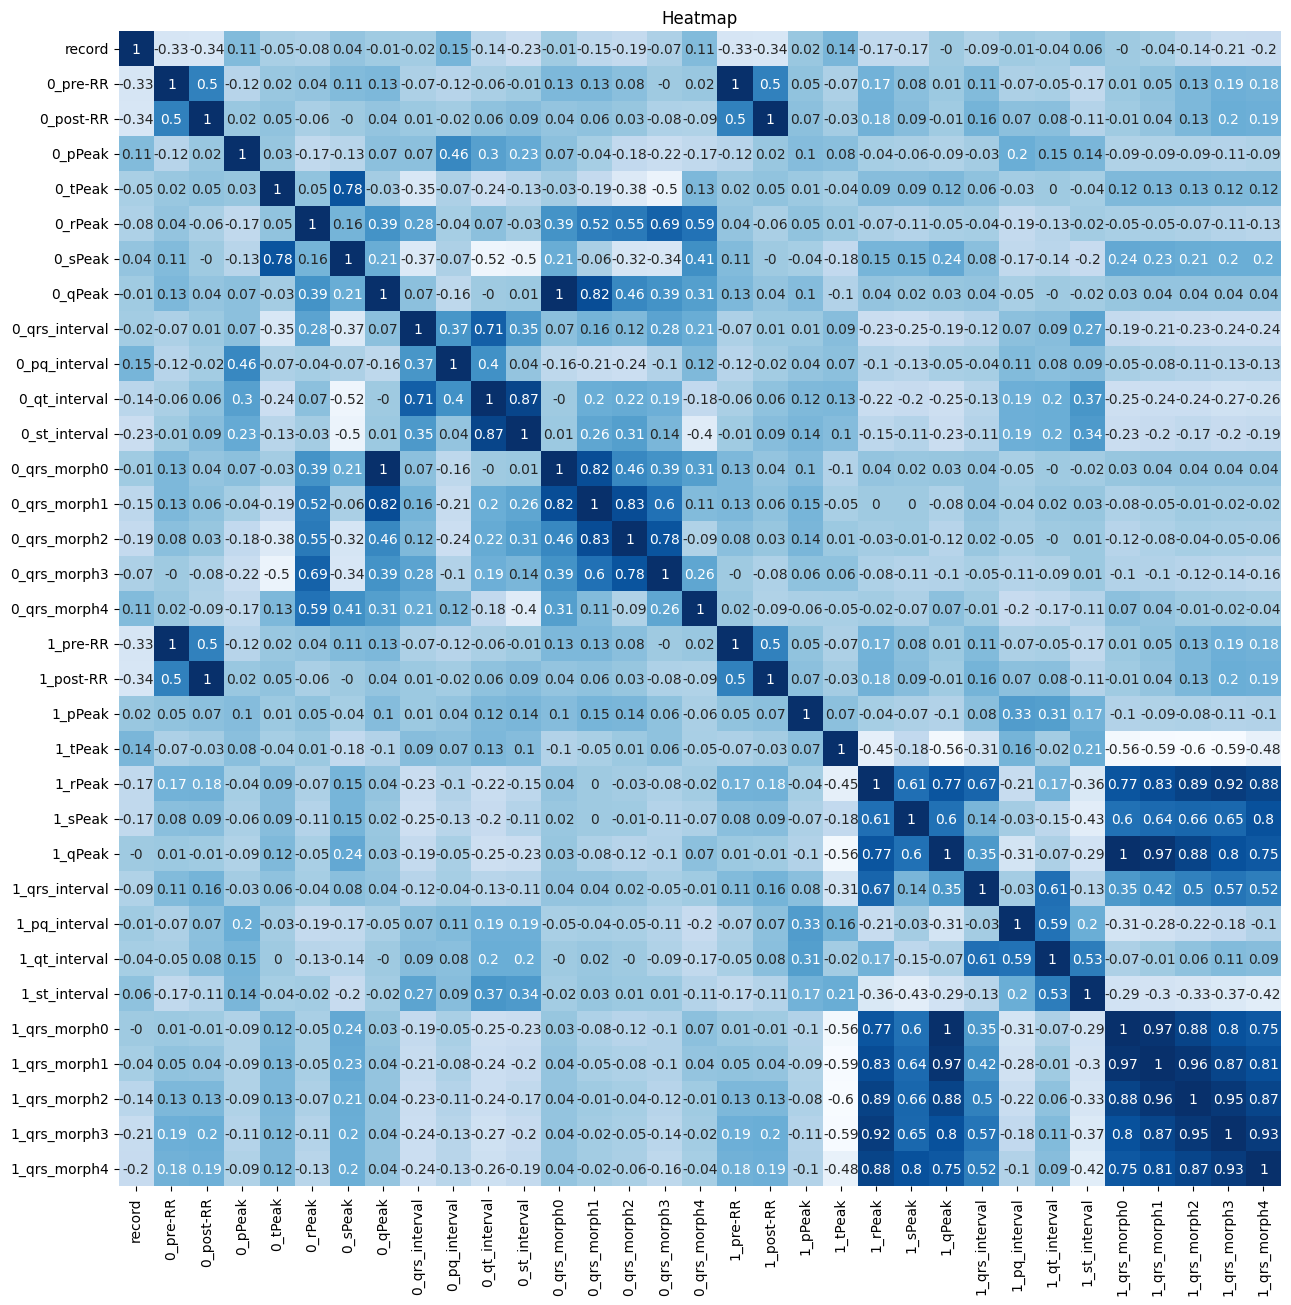

In [23]:
# Draw the correlation heatmap.
plt.figure(figsize=(15, 15))
sns.heatmap(corr, cmap='Blues', annot=True, cbar=False)
plt.title('Heatmap')
plt.show()

In [24]:
# List the highly correlated columns.
cor_rem = ['1_pre-RR', '1_post-RR', '0_qrs_morph0', '1_qrs_morph0', 
               '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4']

In [25]:
# Remove the highly correlated columns.
de = de.drop(columns=cor_rem)

In [26]:
# Show the shape of de.
de.shape

(100689, 26)

## Second Training

### Logistic Regression Algorithm

In [27]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9521


### Random Forest Classifier

In [28]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9991


### Gradient Boosting Classifier

In [29]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9933


### XGB Classifier

In [30]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_gbc, y_val, y_pred = xgb_score(xgb_params)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9951


In [31]:
# Define numerical columns and split into two sets.
df = de.copy()
col_out = df.drop(columns="type").columns.to_list()
set_one = col_out[:13]
set_two = col_out[14:]

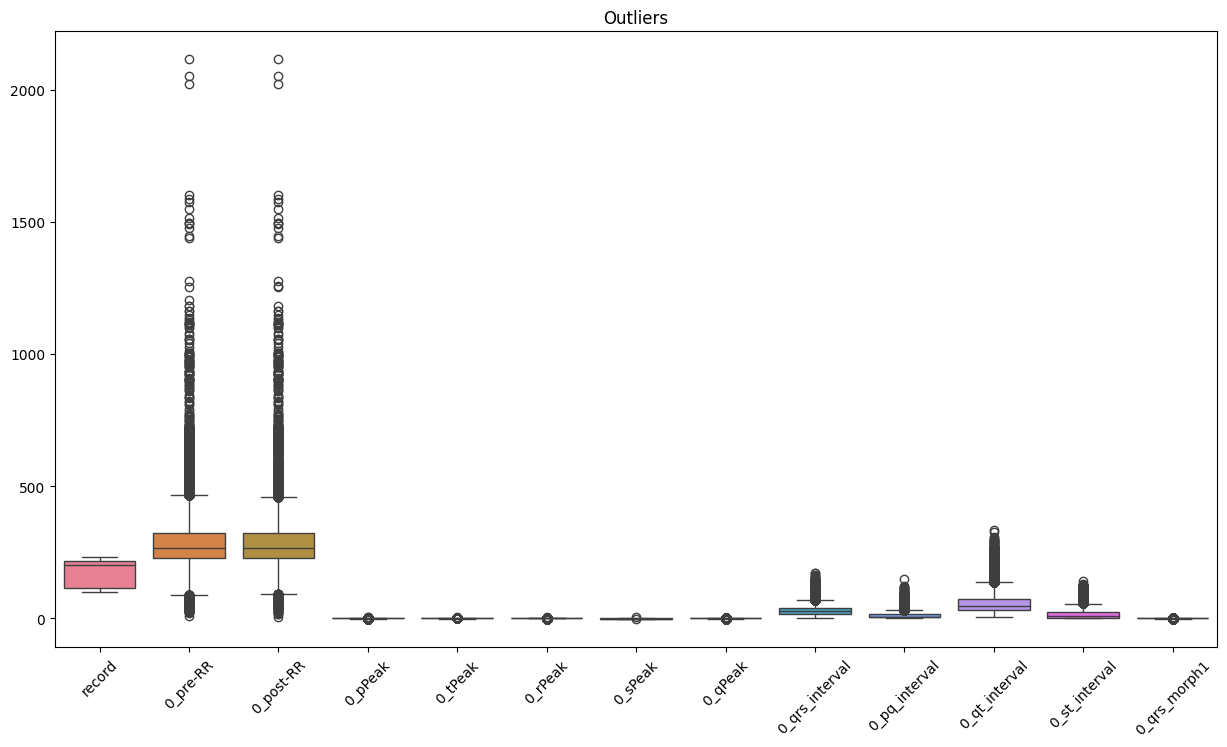

In [32]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_one])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show()

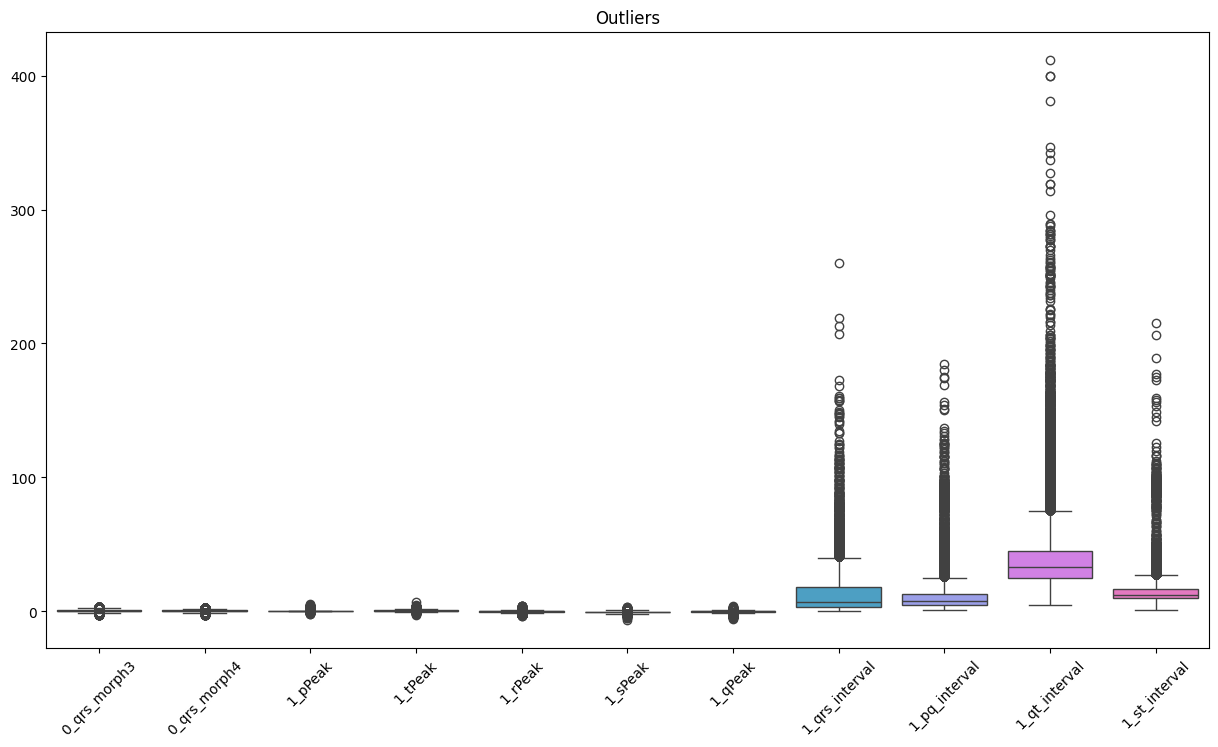

In [33]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_two])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

In [34]:
# Function to remove_outlier with quantile.
def remove_outlier(df_in, col_name):
    for col in col_name:
        q1 = df_in[col].quantile(0.1)
        q3 = df_in[col].quantile(0.9)
        iqr = q3 - q1
        lower = q1 - (1.5 * iqr)
        upper = q3 + (1.5 * iqr)
        df_out = df_in[~((df_in[col] < lower) | (df_in[col] > upper))]
        df_in = df_out
    
    return df_in

In [35]:
# Define the columns for outlier removal.
out_rem = ['0_pre-RR', '0_post-RR', '0_qrs_interval', '0_pq_interval', '0_qt_interval', 
           '0_st_interval', '1_qrs_interval', '1_pq_interval', '1_qt_interval', '1_st_interval']

In [36]:
# Remove outliers.
df = remove_outlier(df, out_rem)

In [37]:
# Show the shape of df.
df.shape

(98644, 26)

In [38]:
# Get percentage of data lost.
round(((100689 - 98644) * 100 / 100689), 2)

2.03

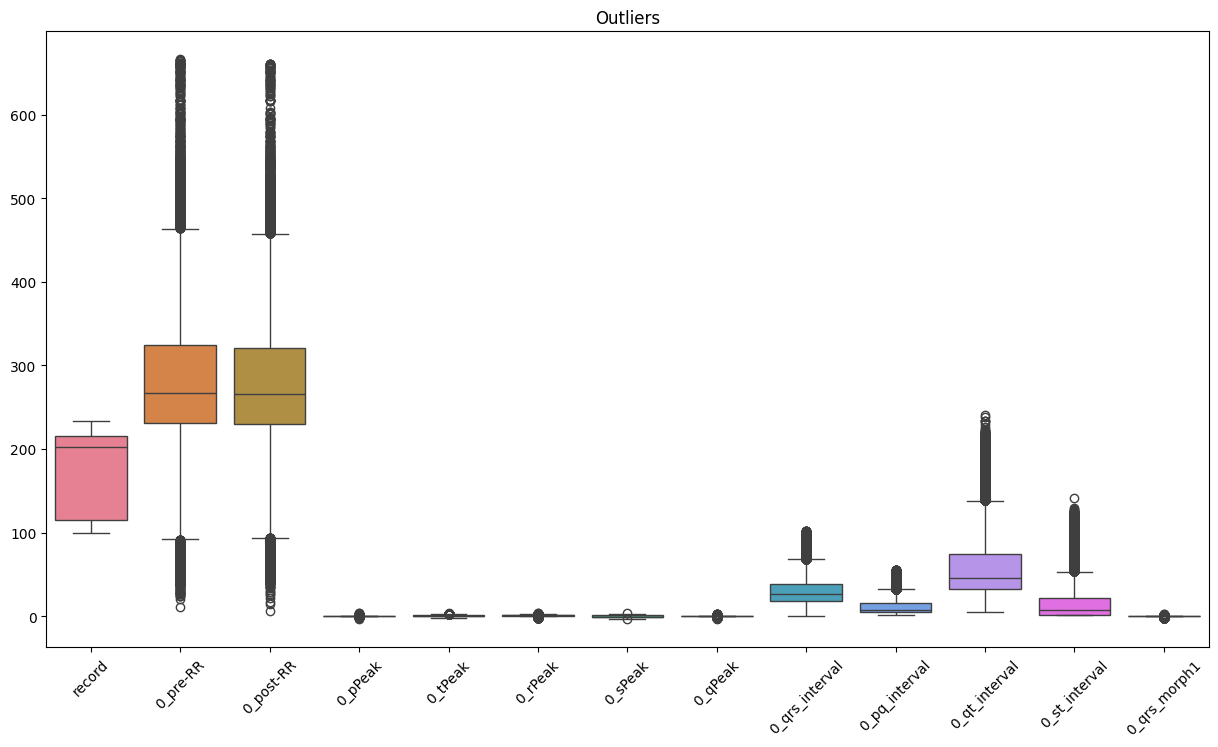

In [39]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=df[set_one])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show()

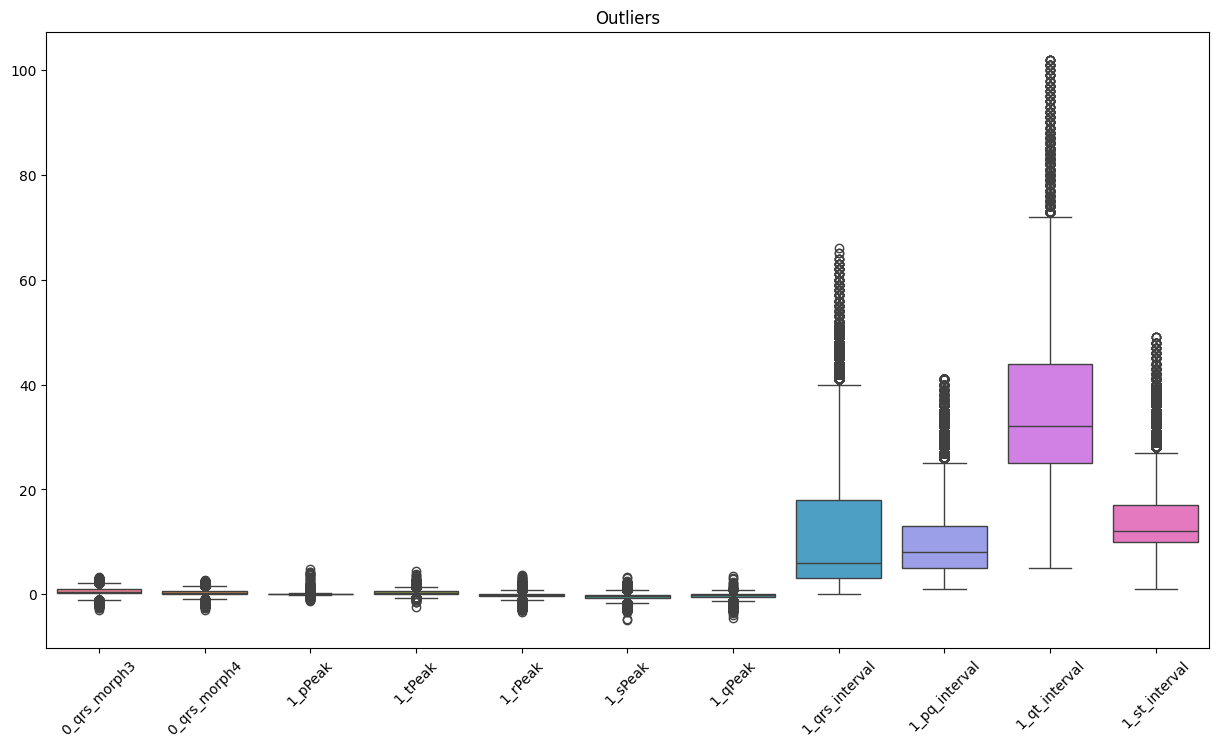

In [40]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=df[set_two])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show()

## Logistic Regression

### Train Model

In [41]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9521


In [42]:
# Define ROC curve plot function.
def roc_curve_draw(y_val, y_pred):
    plt.figure(figsize=(5, 5))
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, label='probability')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

    plt.title('ROC Curve')
    plt.legend()
    
    return plt.show()

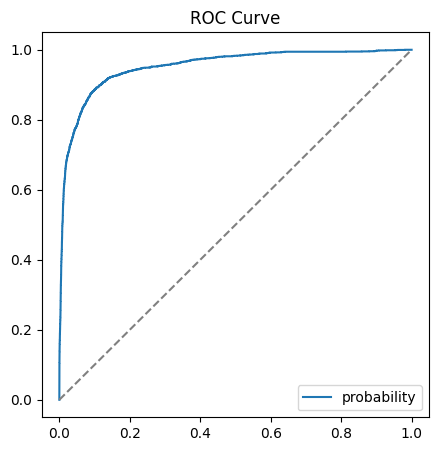

In [43]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [44]:
# Define the confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [45]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2029,3921,122,14066
20,0.2,1917,1888,234,16099
30,0.3,1735,1014,416,16973
40,0.4,1587,611,564,17376
50,0.5,1495,411,656,17576
60,0.6,1401,301,750,17686
70,0.7,1294,229,857,17758
80,0.8,1136,181,1015,17806
90,0.9,829,100,1322,17887


### Precision and Recall

In [46]:
# Define the precision-recall plot function.
def pre_rec_plot(df_scores):
    # Calculate the precision and recall.
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)  
    
    # Plot the curves.
    plt.plot(df_scores.threshold, df_scores.p, label='precision')
    plt.plot(df_scores.threshold, df_scores.r, label='recall')

    plt.title('Precision-Recall Curves')
    plt.legend()
    
    return plt.show()

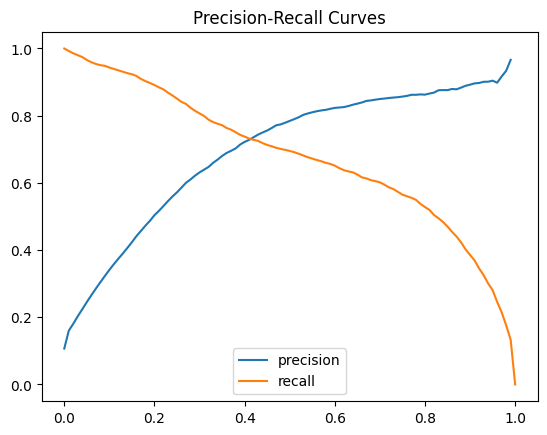

In [47]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [48]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [49]:
# Get the maximum f1-score.
f1_max_lr = df_scores['f1'].max()
print(f'f1_max_lr = {round(f1_max_lr, 4)}')

f1_max_lr = 0.7372


In [50]:
# Define the f1 plot function.
def f1_plot(df_scores):
    plt.plot(df_scores.threshold, df_scores.f1)
    plt.xticks(np.linspace(0, 1, 11))
    plt.title('F1 Curve')
    
    return plt.show()

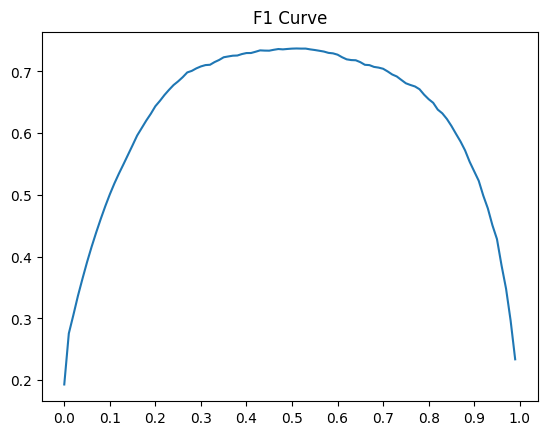

In [51]:
# Plot the F1 scores.
f1_plot(df_scores)

## Random Forest Classifier

### Train Model

In [52]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9991


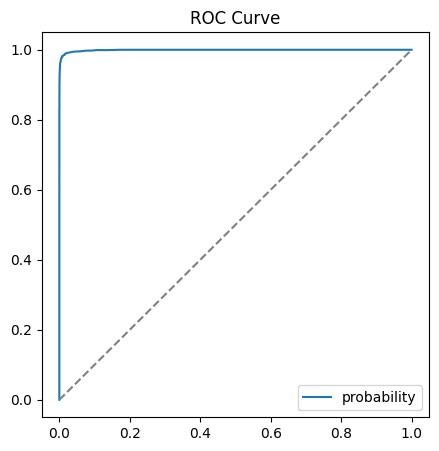

In [53]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [54]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2143,1183,8,16804
20,0.2,2135,546,16,17441
30,0.3,2123,281,28,17706
40,0.4,2110,150,41,17837
50,0.5,2089,78,62,17909
60,0.6,2064,39,87,17948
70,0.7,1998,15,153,17972
80,0.8,1915,7,236,17980
90,0.9,1744,1,407,17986


### Precision and Recall

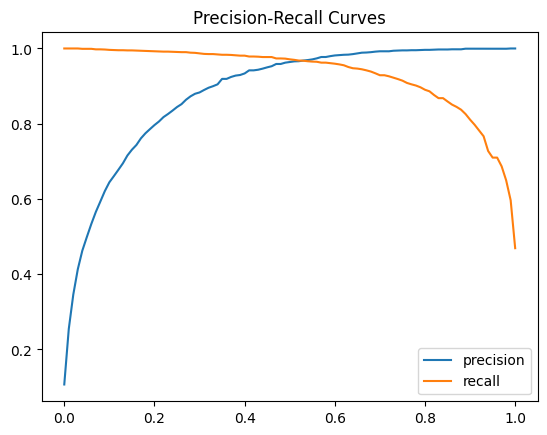

In [55]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [56]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [57]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9704


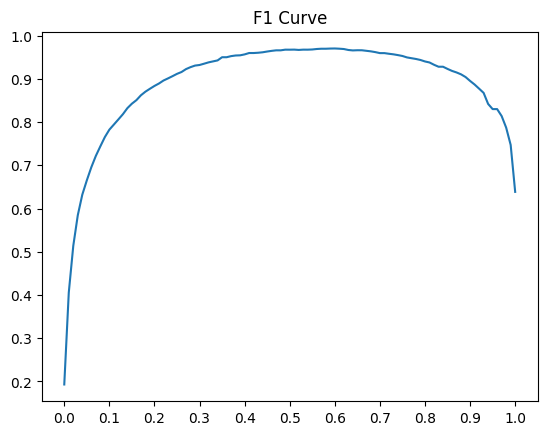

In [58]:
# Plot the F1 scores.
f1_plot(df_scores)

## Gradient Boosting Classifier

In [59]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9933


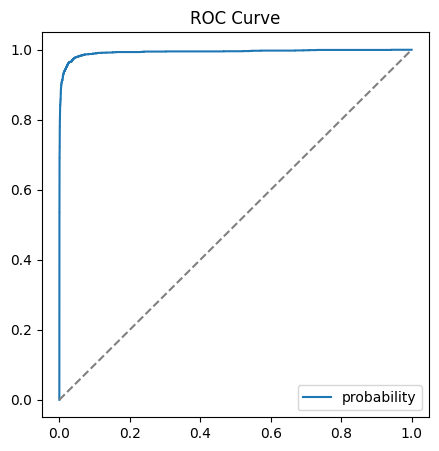

In [60]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [61]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2134,2572,17,15415
20,0.2,2123,1332,28,16655
30,0.3,2107,902,44,17085
40,0.4,2079,622,72,17365
50,0.5,2062,434,89,17553
60,0.6,2028,296,123,17691
70,0.7,1986,179,165,17808
80,0.8,1914,86,237,17901
90,0.9,1763,35,388,17952


### Precision and Recall

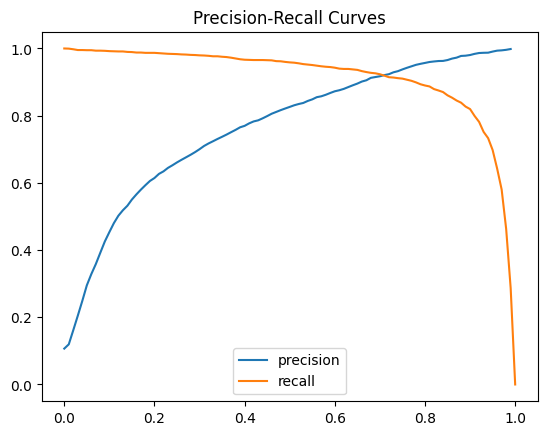

In [62]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [63]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [64]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9248


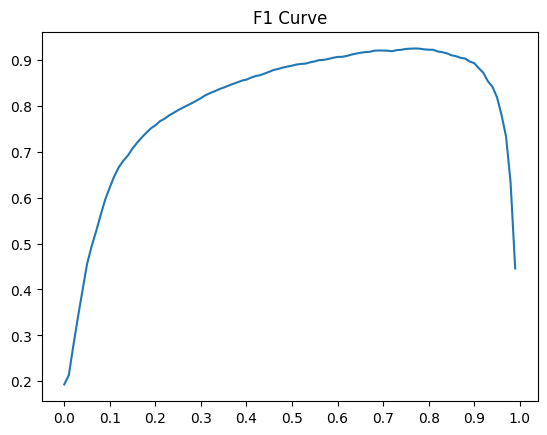

In [65]:
# Plot the F1 scores.
f1_plot(df_scores)

### XGB Classifier

In [67]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_xgb = 0.9951


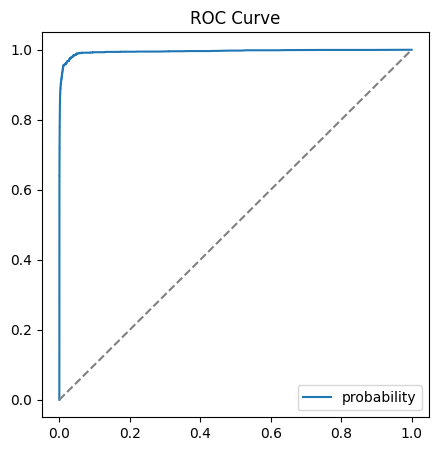

In [68]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [69]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2136,2046,15,15941
20,0.2,2132,1131,19,16856
30,0.3,2117,751,34,17236
40,0.4,2093,522,58,17465
50,0.5,2070,359,81,17628
60,0.6,2057,237,94,17750
70,0.7,2008,149,143,17838
80,0.8,1940,74,211,17913
90,0.9,1775,26,376,17961


### Precision and Recall

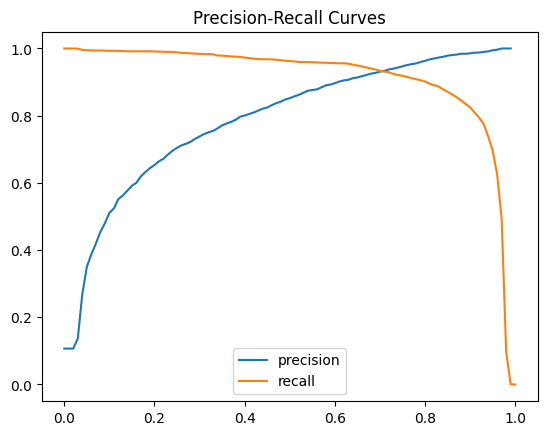

In [70]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [71]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [72]:
# Get the maximum f1-score.
f1_max_xgb = df_scores['f1'].max()
print(f'f1_max_xgb = {round(f1_max_xgb, 4)}')

f1_max_xgb = 0.9335


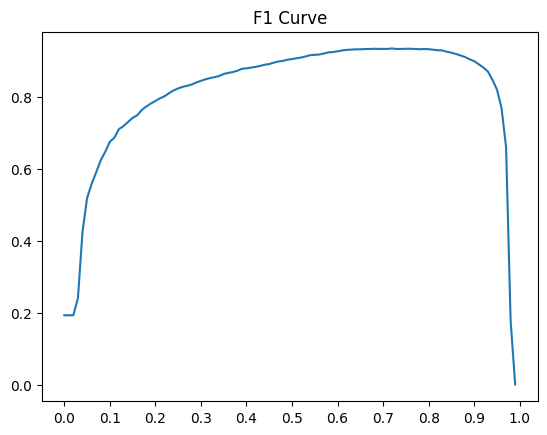

In [73]:
# Plot the F1 scores.
f1_plot(df_scores)

## Feature Importances

### Logistic Regression

In [74]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [75]:
# Apply the feature elimination technique.
original_score = score_lra
scores = pd.DataFrame(columns=['eliminated_feature', 'score_lr', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values
    
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [76]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_lr,difference
1,0_pre-RR,0.893880,0.058220
2,0_post-RR,0.934981,0.017119
0,record,0.939555,0.012545
5,0_rPeak,0.939842,0.012258
4,0_tPeak,0.945738,0.006362
17,1_tPeak,0.947769,0.004331
13,0_qrs_morph2,0.948274,0.003826
6,0_sPeak,0.948295,0.003805
18,1_rPeak,0.948452,0.003648
3,0_pPeak,0.948504,0.003596


### Random Forest Classifier

In [77]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [78]:
# Apply the feature elimination technique.
original_score = score_rfc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_rf', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [79]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_rf,difference
1,0_pre-RR,0.997193,0.001907
3,0_pPeak,0.997744,0.001356
2,0_post-RR,0.997766,0.001334
12,0_qrs_morph1,0.997987,0.001113
17,1_tPeak,0.997992,0.001108
0,record,0.998074,0.001026
16,1_pPeak,0.998153,0.000947
10,0_qt_interval,0.998320,0.000780
15,0_qrs_morph4,0.998429,0.000671
20,1_qPeak,0.998430,0.000670


### Gradient Boosting Classifier

In [80]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [81]:
# Apply the feature elimination technique.
original_score = score_gbc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_gb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = GradientBoostingClassifier(n_estimators=100, random_state=22)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [82]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_gb,difference
1,0_pre-RR,0.982780,0.010520
2,0_post-RR,0.988900,0.004400
0,record,0.989841,0.003459
6,0_sPeak,0.989867,0.003433
5,0_rPeak,0.989940,0.003360
7,0_qPeak,0.990279,0.003021
17,1_tPeak,0.990283,0.003017
9,0_pq_interval,0.990417,0.002883
14,0_qrs_morph3,0.990443,0.002857
19,1_sPeak,0.990474,0.002826


### XGB Classifier

In [83]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [84]:
# Apply the feature elimination technique.
original_score = score_xgb
scores = pd.DataFrame(columns=['eliminated_feature', 'score_xgb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)
    
    features_x = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features_x = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features_x]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_x)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_x)
    
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'binary:logistic',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    mod_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

    y_pred = mod_xgb.predict(dval)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [85]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_xgb,difference
1,0_pre-RR,0.987025,0.008068
2,0_post-RR,0.991350,0.003743
0,record,0.991814,0.003279
11,0_st_interval,0.992597,0.002496
8,0_qrs_interval,0.992602,0.002491
24,1_st_interval,0.992758,0.002335
15,0_qrs_morph4,0.992780,0.002313
23,1_qt_interval,0.992849,0.002244
16,1_pPeak,0.992881,0.002212
13,0_qrs_morph2,0.992888,0.002205


## Model Tuning

### Logistic Regression

In [86]:
# Create function to train the kfold.
def train_kfold(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [87]:
# Create function to predict the kfold.
def predict_kfold(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [88]:
# Copy the data to be used.
df = de.copy()

In [89]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [90]:
# Define the columns.
columns = df.drop(columns='type').columns.to_list()

In [91]:
# Initiate the kfold.
kfold = KFold(n_splits=5, shuffle=True, random_state=22)

the_scores = []

for C in tqdm([x / 40.0 for x in range(16, 33, 1)]):

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['type'].values
        y_val = df_val['type'].values

        dv, model = train_kfold(df_train, y_train, C=C)
        y_pred = predict_kfold(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    the_scores.append((C, np.mean(scores)))

df_scores = pd.DataFrame(the_scores, columns=['C', 'score'])

  0%|          | 0/17 [00:00<?, ?it/s]

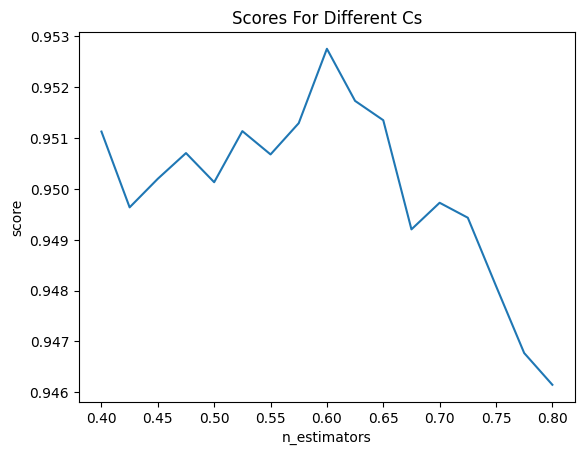

In [92]:
# Plot the scores.
plt.plot(df_scores.C, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different Cs')
plt.show()

In [93]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9528


In [94]:
# Get the index of the maximum score .
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 8


In [95]:
# Find the C at the index.
max_C = df_scores.C[index]
print(f'max_C = {max_C}')

max_C = 0.6


### Random Forest Classifier

#### For n_estimators

In [96]:
# Copy the data to be used.
df = de.copy()

In [97]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [98]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 20)):
    rfc = RandomForestClassifier(n_estimators=n, random_state=22, n_jobs=-1)
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

  0%|          | 0/6 [00:00<?, ?it/s]

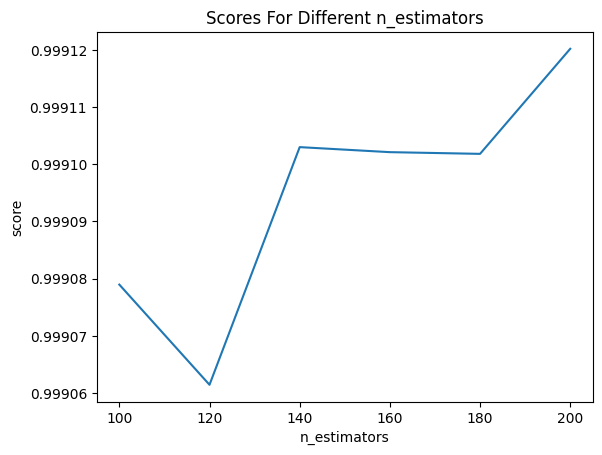

In [99]:
# Plot the scores.
plt.plot(df_scores.n_estimators, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different n_estimators')
plt.show()

In [100]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9991


In [101]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 5


In [102]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


#### For max_depth

In [103]:
# Copy the data to be used.
df = de.copy()

In [104]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [105]:
# Find the best maximum depth.
scores = []

for d in tqdm([2, 4, 6, 8]):
    rfc = RandomForestClassifier(n_estimators=0,
                               max_depth=d,
                               random_state=22, 
                               n_jobs=-1)

    for n in tqdm(range(100, 201, 25)):
        rfc.n_estimators = n
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

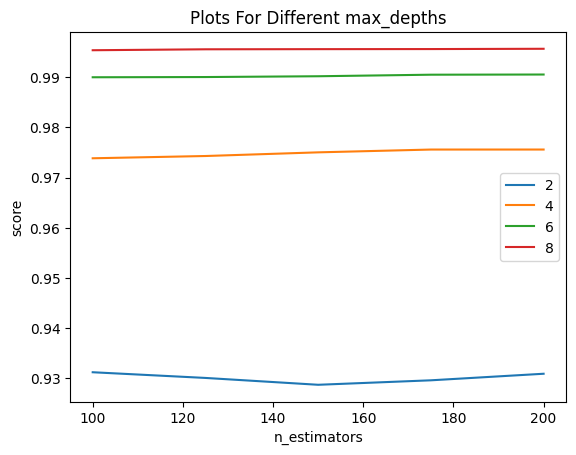

In [106]:
# Plot the scores.
for d in [2, 4, 6, 8]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.score, label=d)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Plots For Different max_depths')
plt.legend()
plt.show()

In [107]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9957


In [108]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 19


In [109]:
# Find the d at the index.
max_d = df_scores.max_depth[index]
print(f'max_d = {max_d}')

max_d = 8


In [110]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


### Gradient Boosting Classifier

#### For n_estimators

In [111]:
# Copy the data to be used.
df = de.copy()

In [112]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [113]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 20)):
    gbc = GradientBoostingClassifier(n_estimators=n, random_state=22)
    gbc.fit(X_train, y_train)
    
    y_pred = gbc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

  0%|          | 0/6 [00:00<?, ?it/s]

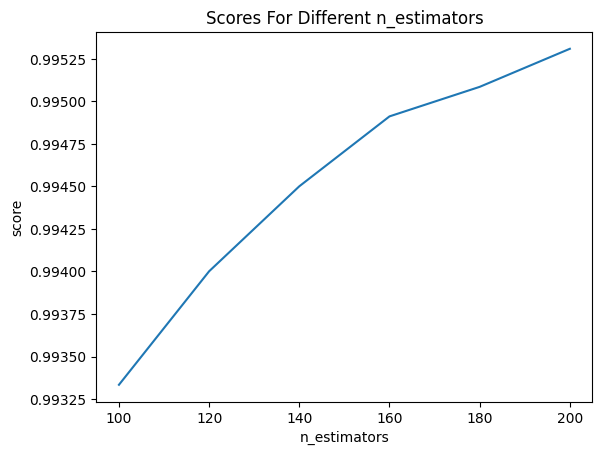

In [114]:
# Plot the scores.
plt.plot(df_scores.n_estimators, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different n_estimators')
plt.show()

In [115]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9953


In [116]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 5


In [117]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


#### For learning_rate

In [118]:
# Copy the data to be used.
df = de.copy()

In [119]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [120]:
# Find the best learning rate.
scores = []

for l in tqdm([0.1, 0.2, 0.3]):
    gbc = GradientBoostingClassifier(n_estimators=0, learning_rate=l, random_state=22)

    for n in tqdm(range(100, 201, 20)):
        gbc.n_estimators = n
        gbc.fit(X_train, y_train)

        y_pred = gbc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((l, n, score))

columns = ['learning_rate', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

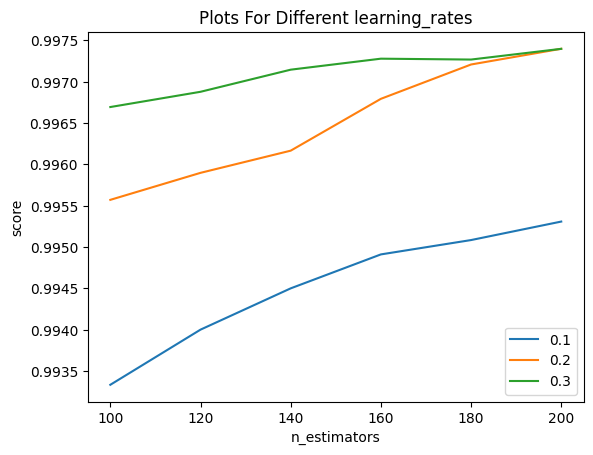

In [121]:
# Plot the scores.
for l in [0.1, 0.2, 0.3]:
    df_subset = df_scores[df_scores.learning_rate == l]
    plt.plot(df_subset.n_estimators, df_subset.score, label=l)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Plots For Different learning_rates')
plt.legend()
plt.show()

In [122]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9974


In [123]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 11


In [124]:
# Find the l at the index.
max_l = df_scores.learning_rate[index]
print(f'max_l = {max_l}')

max_l = 0.2


In [125]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


### XGB Classifier

In [126]:
# Copy the data to be used.
df = de.copy()

In [127]:
# Define a function to parse the output.
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [128]:
# Get dtrain and dval.
dtrain, dval, _ = get_dicts(df)

In [129]:
# Initialize the process.
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [130]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [131]:
# Store values for 'eta=0.3'.
scores['eta=0.1'] = parse_xgb_output(output)

In [132]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [133]:
# Store values for 'eta=0.3'.
scores['eta=0.3'] = parse_xgb_output(output)

In [134]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [135]:
# Store values for 'eta=0.5'.
scores['eta=0.5'] = parse_xgb_output(output)

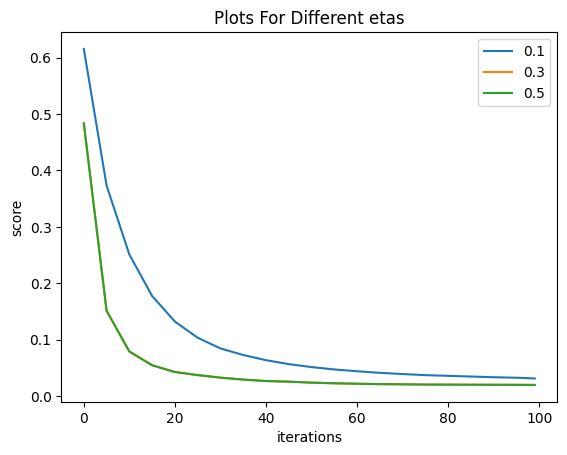

In [136]:
# Inspect the results.
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.plot(scores['eta=0.5'].num_iter, scores['eta=0.3'].val_auc, label='0.5')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Plots For Different etas')
plt.legend()
plt.show()

In [137]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [138]:
# Store values for 'max_depth=4'.
scores['max_depth=4'] = parse_xgb_output(output)

In [139]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 8,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [140]:
# Store values for 'max_depth=8'.
scores['max_depth=8'] = parse_xgb_output(output)

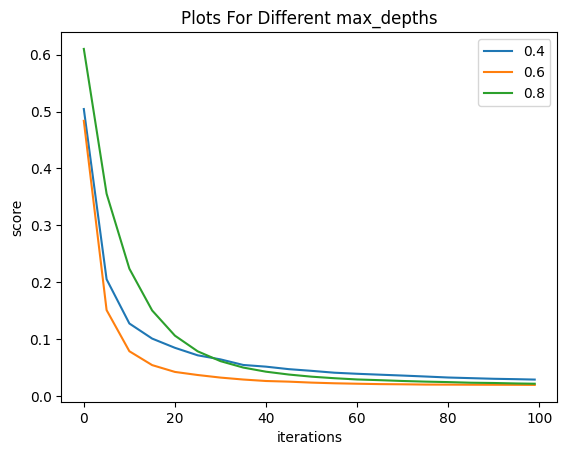

In [141]:
# Inspect the results.
plt.plot(scores['max_depth=4'].num_iter, scores['max_depth=4'].val_auc, label='0.4')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.6')
plt.plot(scores['max_depth=8'].num_iter, scores['max_depth=8'].val_auc, label='0.8')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Plots For Different max_depths')
plt.legend()
plt.show()

## Running Time

### Logistic Regression Algorithm

In [142]:
# Time the final model.
start_1 = time.time()

df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=0.5, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

end_1 = time.time()
print(f'time_lra = {round(end_1 - start_1, 2)}')

score_lra = 0.9523
time_lra = 14.24


### Random Forest Classifier

In [143]:
# Time the final model.
start_2 = time.time()

df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

end_2 = time.time()
print(f'time_rfc = {round(end_2 - start_2, 2)}')

score_rfc = 0.9957
time_rfc = 52.92


### Gradient Boosting Classifier

In [144]:
# Time the final model.
start_3 = time.time()

df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

end_3 = time.time()
print(f'time_gbc = {round(end_3 - start_3, 2)}')

score_gbc = 0.9933
time_gbc = 148.35


### XGB Classifier

In [145]:
# Time the final model.
start_4 = time.time()

df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 8,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

end_4 = time.time()
print(f'time_xgb = {round(end_4 - start_4, 2)}')

score_xgb = 0.997
time_xgb = 10.47
